In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch import distributions
import numpy as np

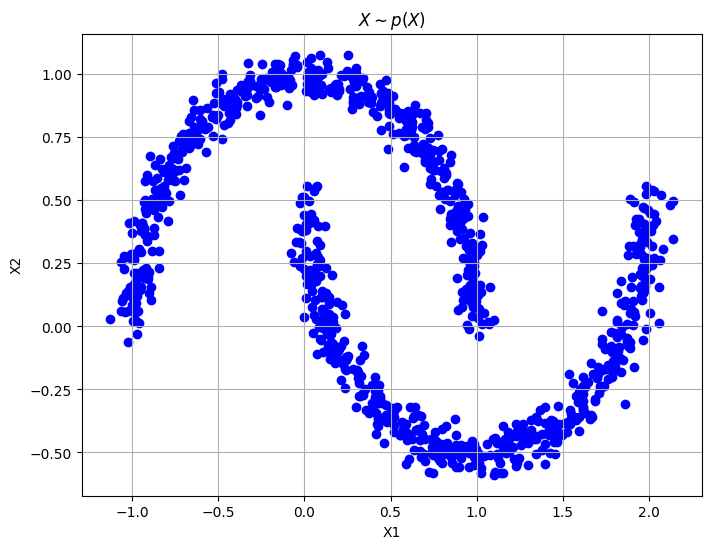

In [ ]:
# Генерация данных с простым распределением
X = make_moons(n_samples=1000, noise=0.05)[0].astype(np.float32)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], color='blue')
plt.title(r'$X \sim p(X)$')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid()
plt.show()

X = torch.FloatTensor(X)
#print(X)

In [ ]:
class AffineCouplingLayer(nn.Module):
    def __init__(self):
        super(AffineCouplingLayer, self).__init__()
        #shift nn для X_a
        self.net_a = nn.Sequential(
            nn.Linear(1, 256),
            #LeakyReLU(x)=max(0,x)+0.01∗min(0,x). Активация.
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            #nn.Tanh()
        )
        #scale nn для X_a
        self.net_b = nn.Sequential(
            nn.Linear(1, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
        )

    #Прямой ход
    def forward(self, x):
        #Делим X выборку на две части X_a и X_b
        x_a, x_b = x.chunk(2, dim=1)
        scale = self.net_b(x_a)
        shift = self.net_a(x_a)
        #Вычисляем b часть Z выборки
        z_b = x_b * torch.exp(scale) + shift
        #Итоговая выборка
        z = torch.cat((x_a, z_b), dim=1)
        #Итоговый якобиан преорбразования
        det_J = scale.sum(dim=1)
        return z, det_J

    #Обратный ход
    def inverse(self, z):
        z_a, z_b = z.chunk(2, dim=1)
        scale = self.net_b(z_a)
        shift = self.net_a(z_a)
        x_b = (z_b - shift) * torch.exp(-scale)
        x = torch.cat((z_a, x_b), dim=1)
        return x

#Actual model
class RealNVP(nn.Module):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList([AffineCouplingLayer() for _ in range(num_coupling_layers)])

    def forward(self, x):
        det_J = 0
        for layer in self.layers:
            x, dj = layer.forward(x)
            det_J += dj
        return x, det_J

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

In [ ]:
# Обучение модели
def train(model, num_epochs=2000, lr=1e-4):
    #выбрали Adam в качестве оптимизатора grad_desc.
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        data = make_moons(n_samples=1000, noise=0.05)[0].astype(np.float32)
        data = torch.FloatTensor(data)
        optimizer.zero_grad()
        z, det_J = model(data)
        log_prob = distributions.MultivariateNormal(torch.zeros(2),
                                                    torch.eye(2)).log_prob(z)
        #В нашем лоссе должен учитываться не только якобиан, но и исходная
        #плотность распределения
        loss = -torch.mean(log_prob + det_J)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Тренируем модель
model = RealNVP(num_coupling_layers=6)
train(model)

Epoch 0, Loss: 2.4835703372955322
Epoch 100, Loss: 1.4735002517700195
Epoch 200, Loss: 1.4001740217208862
Epoch 300, Loss: 1.340003490447998
Epoch 400, Loss: 1.3617550134658813
Epoch 500, Loss: 1.2959667444229126
Epoch 600, Loss: 1.3232420682907104
Epoch 700, Loss: 1.3245279788970947
Epoch 800, Loss: 1.2923413515090942
Epoch 900, Loss: 1.318329095840454
Epoch 1000, Loss: 1.2930488586425781
Epoch 1100, Loss: 1.2845180034637451
Epoch 1200, Loss: 1.2922219038009644
Epoch 1300, Loss: 1.2773240804672241
Epoch 1400, Loss: 1.3354884386062622
Epoch 1500, Loss: 1.2732511758804321
Epoch 1600, Loss: 1.2814738750457764
Epoch 1700, Loss: 1.2921556234359741
Epoch 1800, Loss: 1.2846508026123047
Epoch 1900, Loss: 1.3258874416351318


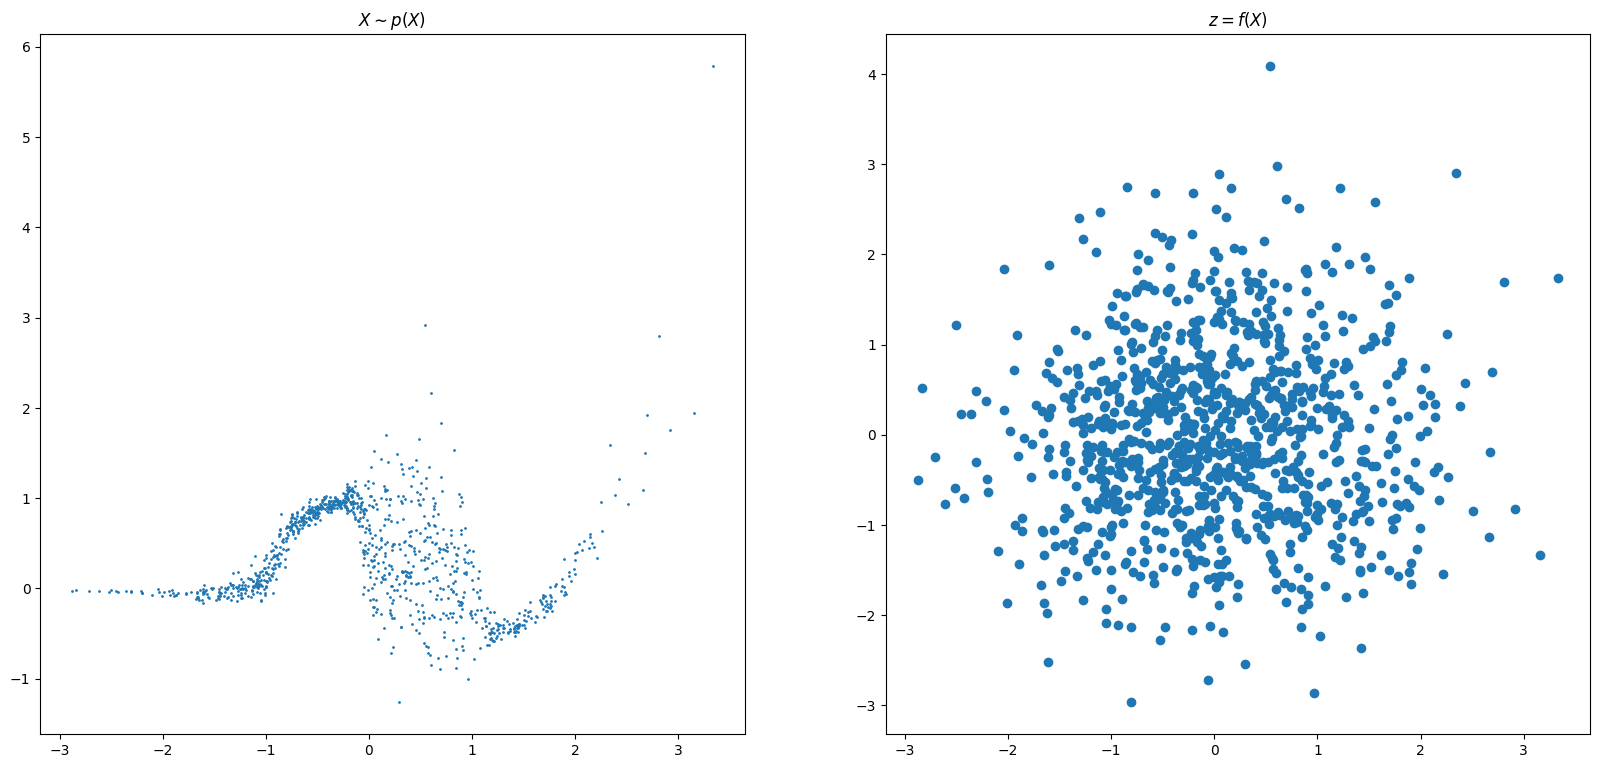

In [ ]:
#Пример получения простой выборки по случайно выбранным данным
with torch.no_grad():
    #многомерное нормальное, наш случай
    z = torch.randn(1000, 2)
    samples = model.inverse(z)
    plt.figure(figsize=(20, 20))
    plt.subplot(221)
    plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), s=1)
    plt.title('$X \sim p(X)$')

    plt.subplot(222)
    plt.scatter(z[:, 0], z[:, 1])
    plt.title(r'$z = f(X)$')

    plt.show()

**По итогу модель сходится, но почему-то не совсем туда, куда хотелось бы. По краям действительно видно moon датасет, но в центре кривые размываются. Возможно нужно поиграться с параметрами, чтобы лосс был < 0.5, чтобы прямо как в статье реализовать.**